Lab 5: GIS Tools in Python
======================

This lab explores several of the the geoprocessing capabilities of 
the geopandas package, and reviews some elements of geovisualization 
using matplotlib. 


Import Packages
------------------------

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd

Read Shapefiles
------------------------

We begin by reading linestring and polygon shapefiles into separate 
geopandas DataFrames. 

The first two files are features in California, which will be used to demonstrate clipping, buffering, and merging shapefiles of different 
types, and with different coordinate reference systems. The third file 
contains features in Texas, which will be used to review data vizualization.

In [2]:
routes_df = gpd.read_file(r'c:\users\rache\Documents\GitHub\GIS_3\Truck_Route_Network.shp')
tracts_df = gpd.read_file(r'c:\users\rache\Documents\GitHub\GIS_3\clinics.shp')
tx = gpd.read_file(r'c:\users\rache\Documents\GitHub\GIS_3\texas.shp')

We can view each shapefile's features using a simple .plot() function:

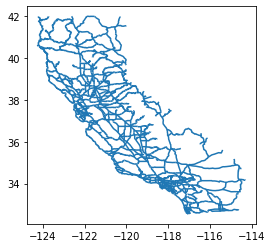

In [3]:
#Truck routes throughout the State of California
routes_df.plot()

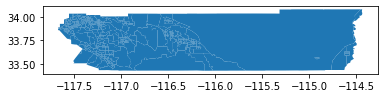

In [4]:
#Census tracts in Riverside County, CA
tracts_df.plot()

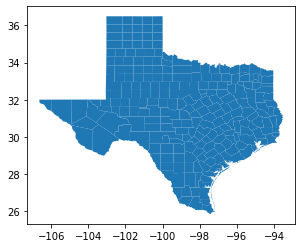

In [5]:
#Counties in the State of Texas
tx.plot()

Clip Features
------------------------

Our California shapefiles include truck routes for the entire state, but 
census tracts only for Riverside County. We can 'clip' the routes to include
only those that are contained within the county border for better vizualization. 

First, we dissolve the tracts file so it consists of a single unified boundary. 

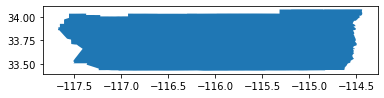

In [5]:
tracts_df['dummy'] = 1
county = tracts_df.dissolve(by='dummy')
county.plot()

Next, we use a loop to identify which route linestrings fall within our 
unified county boundary. 

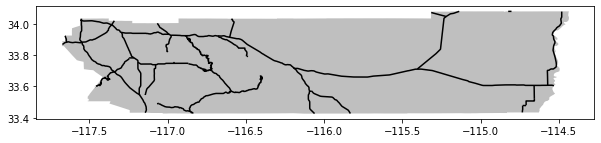

In [6]:
r = routes_df['geometry']

geoms = []
for id, route in enumerate(r):
    geoms.append(route.intersection(county.iloc[0]['geometry']))
    
riverside_hw = gpd.GeoDataFrame({'geometry': geoms})

plt.rcParams['figure.figsize'] = (10, 8)
ax = plt.gca()
riverside_hw.plot(ax=ax, edgecolor='k')
county.plot(ax=ax, facecolor='grey', alpha = 0.5)
plt.show()

In order to merge the two data frames, they must have the same CRS:

In [7]:
tracts_df.crs

{'init': 'epsg:4269'}

In [8]:
riverside_hw.crs

The riverside_hw dataframe does not have a CRS. Below, we set it
equal to the tracts_df CRS. 

In [9]:
riverside_hw.crs = tracts_df.crs # create a crs 
riverside_hw = riverside_hw.to_crs(tracts_df.crs) # update the coordinates accordingly

Create a Buffer
------------------------

In order to determine which tracts are located near a highway, we can 
create a buffer and highlight the tracts that fall within it. 

First, both shapefiles need to use a projected CRS, which allows us to 
measure buffer distance in feet, rather than degrees. 

Then, we can plug our data frame into a create_buffer function that will add a buffer of desired distance and convert the result into a GeoDataFrame object with the desired CRS. 

In [10]:
tracts_df = tracts_df.to_crs(epsg=2230)
riverside_hw = riverside_hw.to_crs(epsg=2230)

In [22]:
def create_buffer(df, distance, crs):
    buffer = df.buffer(distance)
    buffer_df = gpd.GeoDataFrame({'geometry':buffer})
    buffer_df.crs = crs
    return buffer_df

b500 = create_buffer(riverside_hw, 500, riverside_hw.crs)

Spatial Join
---------------

The geopandas function .sjoin() will join shapefiles based on their geometry columns. By specifying that we want an inner join and intersects operation, 
our function will identify only the tracts that intersect with our buffer. 

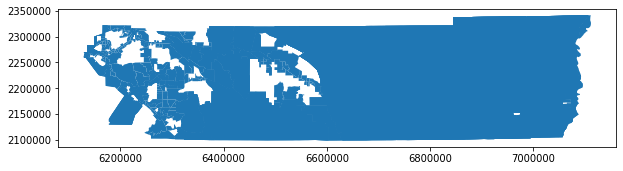

In [23]:
tracts_around_buffer = gpd.sjoin(tracts_df, b500, how='inner', op='intersects')
tracts_around_buffer.plot()

Our tracts_around_dummy dataframe is missing several tracts that do not 
fall within the buffer. Since we want a dataframe with all tracts, we can
create a dummy variable in our original tracts_df with the counties that 
fall within the buffer. 

I did this differently than the module, opting to use a for loop to build
the dummy in a single step, rather than first building a numpy array. This method
may sacrifice some computing efficiency, but it is more easily interpretable. 

In [13]:
tracts_ids = tracts_df['GEOID10'].values
roads_ids = tracts_around_buffer['GEOID10'].values

dummy = []
for id in tracts_ids:
    if id in roads_ids:
        dummy.append(1)
    else:
        dummy.append(0)

tracts_df['intersectshw'] = dummy

Finally, we can plot our result, zooming the map to the boundaries of Riverside County and setting a new color scheme. 

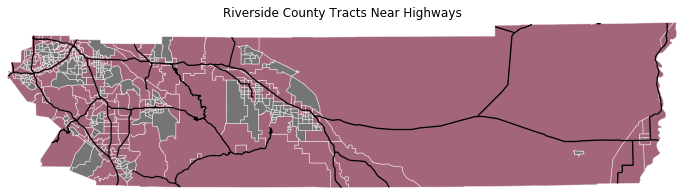

In [15]:
w, s, e, n = tracts_df.total_bounds

fig, ax=plt.subplots(1, figsize=(12, 10))
tracts_df.plot(ax=ax, column='intersectshw', edgecolor='white', 
               
               #adding a '_r' suffix to the color map reverses the order
               cmap='RdGy_r', linewidth = 0.7, alpha=0.6)

riverside_hw.plot(ax=ax, edgecolor='k', linewidth=1.3)
ax.set_xlim(w, e); ax.set_ylim(s, n)
ax.set_title('Riverside County Tracts Near Highways')
ax.set_axis_off()
plt.show()

Choropleth Maps
---------------

The following example highlights some design features of different types of choropleth maps, created with matplotlib. 

Please note: I was not able to run the splot module in the lab. 

C:\Users\rache\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


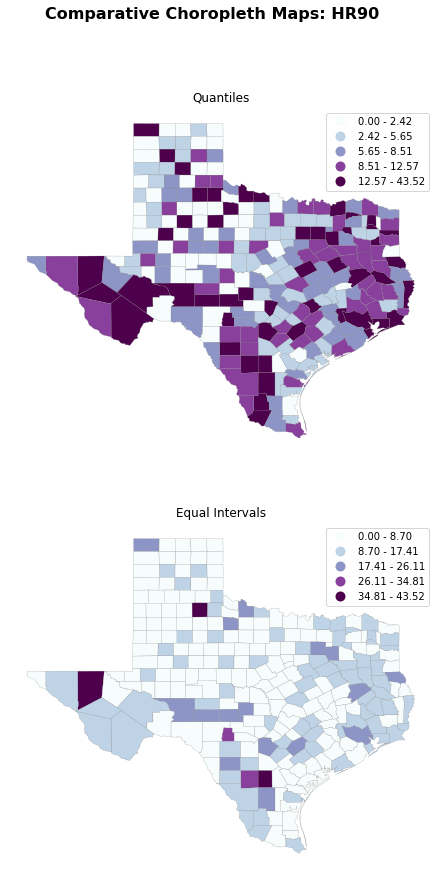

In [25]:
#The subplots argument will create two axes in a single column on the same plot
fig, axs = plt.subplots(2, 1, figsize=(10, 14))

#The first axis contains a quantile map, breaking the frequency of observations into equal groups
tx.plot(ax=axs[0], column='HR90', scheme='QUANTILES', 
        
        #We divide the data into 5 quantiles, set color and line styles, and add a legend
        k=5, cmap='BuPu', linewidth=0.2, edgecolor='grey', legend=True)

#The second axis contains an equal intervals map, breaking observations into bins of equal range
tx.plot(ax=axs[1], column='HR90', scheme='equal_interval', 
        
        #We divide the data into 5 intervals, and set the same style guides as the first axis
        k=5, cmap='BuPu', linewidth=0.2, edgecolor='grey', legend=True)

#Matplotlib requires that we format each axis separately. Here, we refer to the axes by index
axs[0].set_axis_off()
axs[0].set_title('Quantiles')
axs[1].set_axis_off()
axs[1].set_title('Equal Intervals')

#We add a title for the figure overall, and adjust the font 
fig.suptitle('Comparative Choropleth Maps: HR90', fontsize=16, fontweight='bold')
plt.show()